In [806]:
import json
import os
import shutil

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
from scipy.interpolate import splprep, splev


np.set_printoptions(suppress=True)
np.random.seed(2022)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Video to Frames

In [807]:
def video_to_frames(video_path):
    """ Export video to frames, which creates a folder ('frames') in the same folder

    Parameters
    ----------
    video_path : [str]
        the path of the video

    """
    
    # get parent directory
    parent_path = os.path.dirname(video_path)
    
    # open the video
    cap = cv2.VideoCapture(video_path)
    
    fps, nframes = cap.get(cv2.CAP_PROP_FPS), int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    

    # write frame rate under the same parent directory
    with open(os.path.join(parent_path, "fps.txt"), "w") as f:
        
        f.write(str(fps))
        
    # create folder for frames if not exist
    # the folder `frame` is also under the same parent directory
    frame_folder = os.path.join(parent_path, "frames")
    
    
    if not os.path.isdir(frame_folder):
        
        os.makedirs(frame_folder)
    
    # export frames
    for i_frame in tqdm(range(nframes)):
        
        ret, frame = cap.read()
    
        # handle exeception (early None encountered)
        if not ret:
            break
        
        # write each frame into the folder
        cv2.imwrite(os.path.join(frame_folder, f'frame_{i_frame}.jpg'), frame)


In [808]:
# preprocess: video to frames

# # "demo-video-frames/portland-me_20210818_41_corey/portland-me_20210818_41_corey.mp4"
# video_to_frames("demo-video-frames/portland-me_20210818_29_corey/portland-me_20210818_41_corey.mp4")

### Load dataset

In [809]:
def load_toy_frames(folder="toy-data/dataset_images_matlab"):
    
    frames = []
    
    for file in sorted(os.listdir(folder)):
        
        if ".png" in file:
            
            fpath = os.path.join(folder, file)
            
            img = cv2.imread(fpath)
            
            frames.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
    return frames

In [810]:
def load_frames(video_folder, start_time, end_time):
    """ Load frames from the folder with specified start_time & end_time in seconds


    Inputs:
        video_folder: [str], the folder containing video.mp4, folder for frames, txt file for frame rate
        start_time, end_time: [int] in second

    Parameters
    ----------
    video_folder : [str]
        the folder where the video's 'frames' subfolder is
    start_time : [int]
        the start time to load
    end_time : [int]
        the end time to load

    Returns
    -------
    frames : [list[np.ndarray]]
        a list of loaded frames
    fps : [float]
        the original frames per second of the video
    """
    
    # get frame rate
    fr_file = os.path.join(video_folder, 'fps.txt')
    
    fps = None
    
    with open(fr_file, 'r') as f:
    
        fps = float(f.read())
        
        print(f'Video - {video_folder.split("/")[-1]} - fps: {fps}')
    
    # no fps.txt in the folder => probably haven't exported yet
    if not fps:
        raise ValueError('No fps is found!')
    
    start_fr = int(start_time * fps)
    end_fr = int(end_time * fps)
    
    frames = []
    
    print(f'loading video frames from {start_fr} to {end_fr}')
    
    for i_frame in tqdm(range(start_fr, end_fr)):
        
        frame_path = os.path.join(video_folder, 'frames', f'frame_{i_frame}.jpg')
        
        img = cv2.imread(frame_path)

        frames.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
    return frames, fps

In [811]:
# load real video frames
frames, fps = load_frames("../../odometry/demo-video-frames/portland-me_20210818_29_corey", 0, 180)

Video - portland-me_20210818_29_corey - fps: 20.002315999902486
loading video frames from 0 to 3600


  0%|          | 0/3600 [00:00<?, ?it/s]

In [770]:
# # load toy dataset
# frames = load_toy_frames()
# frames = frames 

### Camera Intrinsics (K)

In [812]:
# real video - camera intrinsics
K = np.array([[1304.728954148559, 0.0, 946.9610479577617], 
              [0.0, 1304.2418122900801, 535.7368433856345], 
              [0.0, 0.0, 1.0]])

In [813]:
# # toy data - camera intrinsics
# K = np.array([[615, 0, 320], 
#               [0.0, 615, 240], 
#               [0.0, 0.0, 1.0]])


### Monocular Visual Odometry

In [815]:
class MonocularVisualOdometry:
    
    def __init__(self, 
                 frame_height, 
                 frame_width,
                 K,
                 max_disp_to_track=5,
                 min_num_kps_to_track=100,
                 min_angle_to_triangulate=1,
                 track_window_size=(5, 5)):
        
        # intrinsics
        self.K = K
        
        self.focal = (self.K[0, 0] + self.K[1, 1]) / 2
        
        # (cx, cy)
        self.cxy = (self.K[0, 2], self.K[1, 2])
        
        # image (frame) height & width
        self.height = frame_height
        self.width = frame_width
        
        # init feature detector & params        
        self.detector = cv2.FastFeatureDetector_create(threshold=10, nonmaxSuppression=True)
    
        # init feature tracker & params
        self.min_num_kps_to_track = min_num_kps_to_track
        
        self.track_window_size = track_window_size
        
        self.max_disp_to_track = max_disp_to_track
        
        self.lk_params = dict(winSize=self.track_window_size, 
                              criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.001))
        
    
        # triangulate criteria
        self.min_angle_to_triangulate = min_angle_to_triangulate
    
    
    def detect_kps(self, frame, grid_size=128, max_per_cell=100):

        ht, wd = frame.shape[:2]

        kps = []

        xs, ys = wd // grid_size, ht // grid_size

        for ix in range(xs):

            for iy in range(ys):

                start_y, end_y = iy * grid_size, (iy + 1) * grid_size

                if iy == ys - 1:

                    end_y = ht - 1

                start_x, end_x = ix * grid_size, (ix + 1) * grid_size

                if ix == xs - 1:

                    end_x = wd - 1

                patch = frame[start_y:end_y, start_x:end_x]
                
                patch_kps = sorted(self.detector.detect(patch), key=lambda x: x.response, reverse=True)[:max_per_cell]

                for kp in patch_kps:
                    
                    kps.append(np.array([kp.pt[0] + start_x, kp.pt[1] + start_y]))

        return np.array(kps)
    
    
    def track_kps(self, last_frame, last_kps, curr_frame):
        """Track the keypoints using the Lucas-Kanade method

        Parameters
        ----------
        last_frame : [np.ndarray]
        last_kps : [np.ndarray], shape (N, 2)
        curr_frame : [np.ndarray]

        Returns
        -------
        curr_kps : [np.ndarray], shape (N, 2)
        """
        
        valid_idx = ~np.isnan(last_kps[:, 0])
        
        valid_curr_kps, st, err = cv2.calcOpticalFlowPyrLK(last_frame, 
                                                           curr_frame, 
                                                           last_kps[valid_idx].astype(np.float32), 
                                                           None, 
                                                           **self.lk_params)
        
        
        # verification - 1 : error should be within the range
        st[(err > self.max_disp_to_track).squeeze()] = 0
        
        # verification - 2 : coordinate boundary [0, self.height - 1], [0, self.width - 1]
        st[(valid_curr_kps[:, 0] <= 0) | (valid_curr_kps[:, 1] <= 0)] = 0
        st[(valid_curr_kps[:, 0] >= self.width) | (valid_curr_kps[:, 1] >= self.height)] = 0
        
        # create the mask 
        # => value 1: the ones should be masked out (large error or beyond the boundary)
        mask = (st == 0).squeeze()
        
        valid_curr_kps[mask] = np.nan
        
        curr_kps = np.ones_like(last_kps) * np.nan
        
        curr_kps[valid_idx] = valid_curr_kps

        return curr_kps
            
    def estimate_pose(self, last_kps, curr_kps):
        """Estimate the camera pose with epipolar geometry

        Parameters
        ----------
        last_kps : [np.ndarray], shape (N, 2)
        curr_kps : [np.ndarray], shape (N, 2)
        
        Returns
        -------
        R : [np.ndarray], shape (3, 3)
        T : [np.ndarray], shape (3, 1)
        all_inliers : [np.ndarray], shape (N,)
        """

        valid_idx = ~np.isnan(curr_kps[:, 0])
            
        # note: 
        # mask : 0 & 255
        E, mask = cv2.findEssentialMat(last_kps[valid_idx],
                                       curr_kps[valid_idx],
                                       pp=self.cxy, 
                                       focal=self.focal, 
                                       method=cv2.RANSAC, 
                                       prob=0.999, 
                                       threshold=0.1)

        
        # get the camera pose (of current frame)
        # inliers: 0 & 1
        _, R, T, inliers = cv2.recoverPose(E, 
                                           last_kps[valid_idx], 
                                           curr_kps[valid_idx], 
                                           focal=self.focal, 
                                           pp=self.cxy,
                                           mask=(mask * 255).astype(np.uint8))
        
        inliers = inliers.squeeze().astype(np.bool_)
        
        # back to original size
        all_inliers = (np.zeros(curr_kps.shape[0],)).astype(np.bool_)
        all_inliers[valid_idx] = inliers
        
        return R, T, all_inliers
        
    def triangulate_3d_landmarks(self, 
                                 last_kps, 
                                 last_cam_pose,
                                 curr_kps, 
                                 curr_cam_pose,
                                 inliers=None):
        """Triangulate 3d points with the two views

        Parameters
        ----------
        last_kps : [np.ndarray], shape (N, 2)
        last_cam_pose : [np.ndarray], shape (3, 4)
            last_cam_poses[:3, :3] - the rotation matrix 
            last_cam_poses[:3, [3]] - the translation
        curr_kps : [np.ndarray], shape (N, 2)
        curr_cam_pose : [np.ndarray], shape (3, 4)
            curr_cam_poses[:3, :3] - the rotation matrix
            curr_cam_poses[:3, [3]] - the translation
        inliers : [np.ndarray], shape (N,)
            the inliers during the estimation of essential matrix
            
        Returns
        -------
        kps_3d : [np.ndarray], shape (N, 3)
            the triangulated 3d points
        """
        
        if inliers is None:
            
            inliers = np.ones((curr_kps.shape[0])).astype(np.bool_)
        
        # valid points able to be triangulated
        mask = inliers & (~np.isnan(curr_kps[:, 0]))
        
        if mask.sum() == 0:
        
            return None
        
        valid_last_kps = last_kps[mask]
        valid_curr_kps = curr_kps[mask]

        n_valids = valid_last_kps.shape[0]
        
        inv_K = np.linalg.inv(self.K)
    
        # normalized / calibrated points: (3, n_valids)
        norm_last_kps = inv_K @ (np.concatenate([valid_last_kps, np.ones((n_valids, 1))], 
                                                axis=1).T)
        norm_curr_kps = inv_K @ (np.concatenate([valid_curr_kps, np.ones((n_valids, 1))], 
                                                axis=1).T)

        valid_kps_homo = cv2.triangulatePoints(last_cam_pose,
                                               curr_cam_pose,
                                               norm_last_kps[:2],
                                               norm_curr_kps[:2])
        
        # homogeneous points to 3d points
        valid_kps_3d = cv2.convertPointsFromHomogeneous(valid_kps_homo.T)
        
        # make sure triangulation is good
        
        kps_3d = np.ones((curr_kps.shape[0], 3)) * np.nan
        kps_3d[mask] = valid_kps_3d.squeeze()
        
        kps_3d[kps_3d[:, -1] < 0] = np.nan
        
        return kps_3d
    
    def get_triangulation_angles(self, kps_3d, R, T):
        """Calculate the angles of triangulated points between the two bearing vectors.
        One from the point to the world center; the other from the point to the current camera.

        Parameters
        ----------
        kps_3d : [np.ndarray], shape (N, 3)
        R : [np.ndarray], shape (3, 3)
            the rotation matrix of the current frame (camera)
        T : [np.ndarray], shape (3, 1)
            the translation vector of the current frame (camera)
            
        Returns
        -------
        all_angles : [np.ndarray]
            the bearing angles of all 3d points
        """
        
        mask = ~np.isnan(kps_3d[:, 0])
        
        valid_kps_3d = kps_3d[mask]
        
        vec_in_ref = valid_kps_3d / np.linalg.norm(valid_kps_3d, axis=1)[:, np.newaxis]
        
        vec_in_cam = (valid_kps_3d.T + R.T @ T).T
        vec_in_cam = vec_in_cam / np.linalg.norm(vec_in_cam, axis=1)[:, np.newaxis]
  
        angles = np.arccos((vec_in_ref * vec_in_cam).sum(axis=1)) * 180
    
        all_angles = np.ones((kps_3d.shape[0],)) * np.nan
        all_angles[mask] = angles
        
        return all_angles
    
    def estimate_pose_with_pnp(self, kps_3d, curr_kps):
        """Estimate camera pose using 3D-2D correspondences

        Parameters
        ----------
        kps_3d : [np.ndarray], shape (N, 3)
        curr_kps : [np.ndarray], shape (N, 2)
        
        Returns
        -------
        R : [np.ndarray], shape (3, 3)
            the camera pose (rotation matrix) of the current frame
        T : [np.ndarray], shape (3, 1)
            the camera pose (translation vector) of the current frame
        pnp_inliers : [np.ndarray], shape (3,)
            the inliers during the estimation of the current pose
        """
        
        mask = (~np.isnan(kps_3d[:, 0])) & (~np.isnan(curr_kps[:, 0]))

        _, rvecs, tvecs, pnp_inliers = cv2.solvePnPRansac(kps_3d[mask],
                                                          curr_kps[mask],
                                                          self.K,
                                                          None)
    
        R = cv2.Rodrigues(rvecs)[0]
        T = tvecs

        # note: this inlier is a list of valid indices (not bool mask or 0/1 or 0/255)
        return R, T, pnp_inliers.squeeze()
 
        
    def optimize(self):
        
        pass
     

In [816]:
# Note: => initial start has an effect on the scale (more on visualization) 
# => cause the init frame difference is the reference of the other frames

# # mvo instance for toy dataset
# mvo = MonocularVisualOdometry(frame_height=480,
#                               frame_width=640,
#                               K=K,
#                               max_disp_to_track=5,
#                               min_num_kps_to_track=500,
#                               min_angle_to_triangulate=None,
#                               track_window_size=(5, 5))

# mvo instance for real video
mvo = MonocularVisualOdometry(frame_height=1080,
                              frame_width=1920,
                              K=K,
                              max_disp_to_track=5,
                              min_num_kps_to_track=3000,
                              min_angle_to_triangulate=None,
                              track_window_size=(12, 12))

min_angle = 1
max_angle = 120
min_triangulated_pts = 20

# init poses
poses = []

# set up the first frame
last_frame, last_kps = frames[0], mvo.detect_kps(frames[0])

print(f'initial set of keypoints: {len(last_kps)}')

# vis for debug
show = 0

# show log
verbose = 0

for i in tqdm(range(1, len(frames))):
    
    curr_frame = frames[i]
    
    curr_kps = mvo.track_kps(last_frame, last_kps, curr_frame)
    
    # print(f'tracked size: {(~np.isnan(curr_kps[:, 0])).sum()}')
    
    if (~np.isnan(curr_kps[:, 0])).sum() <= 8:
        
        # < 8 or < 5 would cause pose estimation error
        last_frame, last_kps = frames[i - 1], mvo.detect_kps(frames[i - 1])
        
        curr_kps = mvo.track_kps(last_frame, last_kps, curr_frame)
    
    if show:

        visualize_kps(last_frame, last_kps, curr_frame, curr_kps)

    # estimate the initial pose
    R, T, inliers = mvo.estimate_pose(last_kps, curr_kps)
    
    if R is None:
        
        if verbose: print(f'unable to estimate pose at frame {i}')
            
        poses.append([np.eye(3), np.zeros((3, 1))])
            
        continue
    
    if inliers.sum() < 8:
        
        if verbose: print(f'insufficient inliners for pose at frame {i}')
            
        poses.append([np.eye(3), np.zeros((3, 1))])
        
        continue

    # triangulation
    kps_3d = mvo.triangulate_3d_landmarks(last_kps, 
                                          np.concatenate([np.eye(3), np.zeros((3, 1))], axis=1),
                                          curr_kps, 
                                          np.concatenate([R, T], axis=1),
                                          inliers)
    
    if kps_3d is None:
        
        if verbose: print(f'unable to trianguate at frame {i}')
            
        poses.append([np.eye(3), np.zeros((3, 1))])
        
        continue
    
    # angles
    angles = mvo.get_triangulation_angles(kps_3d, R, T)
    
    if np.nanmedian(angles) < min_angle:
        
        if verbose: print(f'at frame {i}, median angle {np.nanmedian(angles)} is less than {min_angle}')
        
        poses.append([np.eye(3), np.zeros((3, 1))])
        
        continue
    
    valid_angles = np.where((angles > min_angle) & (angles <= max_angle), angles, np.ones_like(angles) * np.nan)
    
    if (~np.isnan(valid_angles)).sum() < min_triangulated_pts:
        
        if verbose: print(f'at frame {i}, not enough 3D pts {(~np.isnan(valid_angles)).sum()} is less than {min_triangulated_pts}')
        
        poses.append([np.eye(3), np.zeros((3, 1))])
        
        continue
            
    # found an adequate frame for initialization
    poses.append([R.copy(), T.copy()])
 
    # redetect
    if (~np.isnan(curr_kps[:, 0])).sum() < mvo.min_num_kps_to_track:

        if verbose:
            print(f"at frame {i} => less than {mvo.min_num_kps_to_track} (current {(~np.isnan(curr_kps[:, 0])).sum()})=> Add new key frame!")

        # re-detect
        curr_kps = mvo.detect_kps(curr_frame)

    # update last frame & last kps
    last_frame = curr_frame
    last_kps = curr_kps
        

initial set of keypoints: 4540


  0%|          | 0/3599 [00:00<?, ?it/s]

### Visualization

In [817]:
## some utils for recovering the trajectory from all the camera poses & reproject trajectory to the ref frame
def get_trajectory_from_poses(poses, K, camera_offset=None):
    """
    Input:
        poses: [a list of [R, T]], R => (3, 3), T => (3, 1)
        K: [np.ndarray], camera intrinsics (3, 3)
        camera_offset: [np.ndarray], shape (3, 1)
    """
    
    trajectory = []
    
    if camera_offset is None:
        
        # simulation for the trajectory on the road
        camera_offset = np.array([[0.], [0.], [0.]])
        
    est_R = np.eye(3)
    est_T = np.zeros((3, 1))
        
    for R, T in poses:
        
        est_T += est_R @ (R.T @ (-T))
        est_R = est_R @ R.T
        
        trajectory.append((est_T.copy() + est_R.copy() @ camera_offset).squeeze())
        
    return np.array(trajectory)

def get_reprojected_trajectory_from_poses(poses, K, camera_offset=None):
    """
    Input:
        poses: [a list of [R, T]], R => (3, 3), T => (3, 1)
        K: [np.ndarray], camera intrinsics (3, 3)
        camera_offset: [np.ndarray], shape (3, 1)
    """
    
    trajectory = get_trajectory_from_poses(poses, K, camera_offset=camera_offset)
    
    projected_trajectory = (K @ trajectory.T).T
    
    projected_trajectory = projected_trajectory[:, :2] / (projected_trajectory[:, [2]] + 1e-10)

    return projected_trajectory
    
    
def export_or_visualize_projected_frame(i_frame, 
                                        frame, 
                                        projected_trajectory, 
                                        export=False, 
                                        export_directory="temp"):
    
    plt.figure(figsize=(5, 3))
    
    plt.imshow(frame)
    
    plt.plot(projected_trajectory[:, 0], projected_trajectory[:, 1], 'r', linewidth=3.5)
    
    plt.xlim([0, frame.shape[1]])
    
    plt.ylim([frame.shape[0], 0])
    
    plt.axis('off')
    
    if export:
        
        plt.savefig(os.path.join(export_directory, "frame_%04d.png" % i_frame), bbox_inches='tight', pad_inches=0)
        
        plt.close()
    
    else:
        
        plt.show()
    

def visualize_kps(last_frame, last_kps, curr_frame, curr_kps, marker_size=5):
    
    valid_idx = ~np.isnan(curr_kps[:, 0])
    
    plt.figure(figsize=(20, 12))
    
    plt.subplot(121)
    plt.imshow(last_frame)
    plt.scatter(last_kps[valid_idx, 0], last_kps[valid_idx, 1], s=marker_size)
    
    plt.subplot(122)
    plt.imshow(curr_frame)
    plt.scatter(curr_kps[valid_idx, 0], curr_kps[valid_idx, 1], s=marker_size)
    
    plt.show()
    
def export_projected_frame(i_frame, 
                           frame, 
                           projected_trajectory, 
                           export=False, 
                           export_directory="temp",
                           color=(255, 51, 51),
                           thickness=8):
    
    export_img = frame.copy()
    
    cv2.polylines(export_img, [projected_trajectory.astype(np.int32)], False, color, thickness=thickness)
    
    export_img = cv2.cvtColor(export_img, cv2.COLOR_RGB2BGR)
    
    cv2.imwrite(os.path.join(export_directory, "frame_%04d.jpg" % i_frame), export_img, [cv2.IMWRITE_JPEG_QUALITY, 100])
    
    

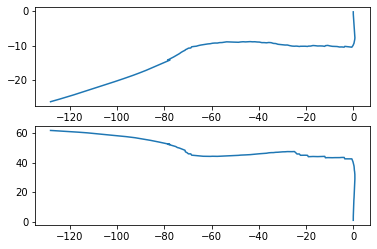

In [795]:
# 3d trajectory
trajectory = get_trajectory_from_poses(poses, K)

# x - y
plt.subplot(211)
plt.plot(trajectory[:, 0], trajectory[:, 1])
# x - z
plt.subplot(212)
plt.plot(trajectory[:, 0], trajectory[:, 2])
plt.show()

In [799]:
# get projected trajectory on the ref image
start_frame = 0
end_frame = start_frame + 200
projected_trajectory = get_reprojected_trajectory_from_poses(poses[start_frame:end_frame], K, camera_offset=np.array([[0.5], [4.0], [16.0]]))

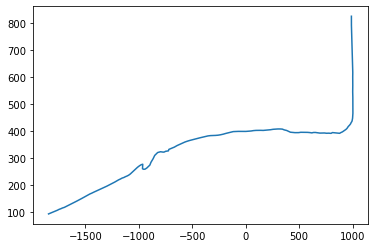

In [800]:
plt.plot(projected_trajectory[:, 0], projected_trajectory[:, 1])

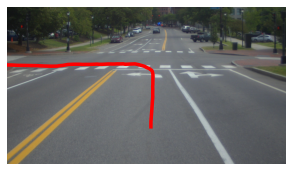

In [801]:
# show the next 10s (trajectory) of the first frame
export_or_visualize_projected_frame(start_frame, frames[start_frame], projected_trajectory)

### Export Reprojected Frames

In [818]:
# the main loop to generate the reprojected frames and export them
# this cell exports the frames 
# and then (manully in terminal)
# (i)  change directory to the specified folder
# (ii) executes $ffmpeg -i frame_%04d.png -vf "fps=[frams-per-second]" [video-name-to-generate].mp4

export_directory = "pureflow-demo-v3-uniform-detect-portland-29"
        
# check export directory
if os.path.isdir(export_directory):

    # if something exists => delete
    shutil.rmtree(export_directory)

os.makedirs(export_directory)

for i_frame in tqdm(range(len(frames) - int(fps))):
    
    # get the next 10 seconds
    end_frame = i_frame + 10 * int(fps)
    
    projected_trajectory = get_reprojected_trajectory_from_poses(poses[i_frame:end_frame].copy(), 
                                                                 K, 
                                                                 camera_offset=np.array([[0.], [4.0], [16.0]]))
    
    export_projected_frame(i_frame, frames[i_frame], 
                            projected_trajectory, 
                            export=True, 
                            export_directory=export_directory)
    
    

  0%|          | 0/3580 [00:00<?, ?it/s]